# preprocess `london` mocks for `spender`

In [1]:
import os, glob
import numpy as np 

In [2]:
import torch

In [3]:
import astropy.io.fits as fits
from astropy.table import Table

In [4]:
from spender.data import desi_qso

In [5]:
import matplotlib.pyplot as plt

In [6]:
desiQSO = desi_qso.DESI()

In [10]:
# i need to figure out what this directory corresponds to...
_dir = '/global/cfs/cdirs/desicollab/mocks/lya_forest/develop/london/qq_desi/v9.0_Y1/v9.0.9.9.9/desi-4.124-4-prod/spectra-16/'

def prepare_spectra(num0, num1, zbin='low', verbose=False): 
    ''' prepare QSO spectra in healpix 
    '''
    # three files in each spectra directory...
    fspec = os.path.join(_dir, '%i/%i/spectra-16-%i.fits' % (num0, num1, num1))
    ftrue = os.path.join(_dir, '%i/%i/truth-16-%i.fits' % (num0, num1, num1))
    frred = os.path.join(_dir, '%i/%i/zbest-16-%i.fits' % (num0, num1, num1))
    
    # read spectra file
    hdulist = fits.open(fspec)
    meta = Table.read(fspec) # meta data
    zbest = Table.read(frred, hdu=1)
    z = zbest['Z'] 
    zerr = zbest['ZERR']
    
    true_cont = Table.read(ftrue, hdu=5)
    
    target_id = meta['TARGETID'] # unique target ID
    
    if zbin == 'low': keep = (z < 2.1) 
    elif zbin == 'high': keep = (z > 2.1) & (z < 3.5)
    
    # read in data
    _wave, _flux, _ivar, _mask = {}, {}, {}, {} # res = {}
    for h in range(2, len(hdulist)):
        if "WAVELENGTH" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _wave[band] = hdulist[h].data
        if "FLUX" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _flux[band] = hdulist[h].data
        if "IVAR" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _ivar[band] = hdulist[h].data
        if "MASK" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _mask[band] = hdulist[h].data
        # no resolution data in the lond mocks 
        #if "RESOLUTION" in hdulist[h].header["EXTNAME"]:
        #    band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
        #    _res[band] = hdulist[h].data
        
    # coadd the b, r, z arm spectra (scraped from
    # https://github.com/desihub/desispec/blob/main/py/desispec/coaddition.py#L529)
    tolerance = 0.001  # A , tolerance reduced
    wave = _wave["b"]
    for b in ["b", "r", "z"]:
        wave = np.append(wave, _wave[b][_wave[b] > wave[-1] + tolerance])
    nwave = wave.size
    ntarget = _flux["b"].shape[0]
    check_agreement = torch.abs(torch.from_numpy(wave) - desiQSO._wave_obs)
    #if check_agreement.max() > 0.01:
    #    print(
    #        "Warning: input wavelength grids inconsistent with class variable wave_obs!"
    #    )
    # check alignment, caching band wavelength grid indices as we go
    windict = {}
    number_of_overlapping_cameras = np.zeros(nwave)
    for b in ["b", "r", "z"]:
        imin = np.argmin(np.abs(_wave[b][0] - wave))
        windices = np.arange(imin, imin + len(_wave[b]), dtype=int)
        dwave = _wave[b] - wave[windices]
        if np.any(np.abs(dwave) > tolerance):
            msg = "Input wavelength grids (band '{}') are not aligned. Use --lin-step or --log10-step to resample to a common grid.".format(
                b
            )
            raise ValueError(msg)
        number_of_overlapping_cameras[windices] += 1
        windict[b] = windices

    flux = np.zeros((ntarget, nwave), dtype=_flux["b"].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    ivar_unmasked = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    mask = np.zeros((ntarget, nwave), dtype=_mask["b"].dtype)

    for b in ["b", "r", "z"]:
        # indices
        windices = windict[b]

        for i in range(ntarget):
            ivar_unmasked[i, windices] += np.sum(_ivar[b][i], axis=0)
            ivar[i, windices] += _ivar[b][i] * (_mask[b][i] == 0)
            flux[i, windices] += _ivar[b][i] * (_mask[b][i] == 0) * _flux[b][i]

            # directly copy mask where no overlap
            jj = number_of_overlapping_cameras[windices] == 1
            mask[i, windices[jj]] = _mask[b][i][jj]

            # 'and' in overlapping regions
            jj = number_of_overlapping_cameras[windices] > 1
            mask[i, windices[jj]] = mask[i, windices[jj]] & _mask[b][i][jj]

    for i in range(ntarget):
        ok = ivar[i] > 0
        if np.sum(ok) > 0:
            flux[i][ok] /= ivar[i][ok]
        ok = ivar_unmasked[i] > 0
            
    # apply bitmask, remove small values
    mask = mask.astype(bool) | (ivar <= 1e-6)
    ivar[mask] = 0

    # explicit type conversion to float32 to get to little endian
    spec = torch.from_numpy(flux[keep].astype(np.float32))
    w = torch.from_numpy(ivar[keep].astype(np.float32))
    target_id = torch.from_numpy(target_id[keep].astype(np.int64))

    # remove regions around skylines
    w[:, desiQSO._skyline_mask] = 0
    
    z = torch.tensor(z[keep].astype(np.float32))
    zerr = torch.tensor(zerr[keep].astype(np.float32))
    true_cont = true_cont[keep]
    
    # normalize spectra:
    norm = torch.zeros(np.sum(keep))
    for i in range(np.sum(keep)):
        # for redshift invariant encoder: select norm window in restframe
        wave_rest = desiQSO._wave_obs / (1 + z[i])
        # wavelength range with no spectral lines
        if zbin == 'low': 
            sel = (w[i] > 0) & (wave_rest > 2500) & (wave_rest < 2700) #(wave_rest > 5300) & (wave_rest < 5850)
        elif zbin == 'high': 
            # this wavelength range is set by the CIII absorprtion wavelengths. 
            # CIII absorption is small and thus should not contribute significantly
            # to estimating the normalization
            sel = (w[i] > 0) & (wave_rest > 1600) & (wave_rest < 1800) #(wave_rest > 5300) & (wave_rest < 5850)
        else: 
            raise NotImplementedError
        if sel.count_nonzero() > 0:
            norm[i] = torch.median(spec[i][sel])
        # remove spectra (from training) for which no valid norm could be found
        if not torch.isfinite(norm[i]):
            norm[i] = 0
        else:
            spec[i] /= norm[i]
        w[i] *= norm[i]**2

    # selects finite fluxes
    keep = (spec.isfinite().sum(axis=-1) == nwave).numpy()
    if verbose: print("%i, %i --- keep: %d / %d"%(num0, num1, keep.sum(),len(keep)))
    return spec[keep], w[keep], z[keep], target_id[keep],  norm[keep], zerr[keep], true_cont['TRUE_CONT'][keep]

test preprocessing

In [8]:
# save QSO spectra to batch
spec, w, z, target_id, norm, zerr, true_cont = prepare_spectra(0, 0, zbin='high')

0, 0 --- keep: 546 / 546


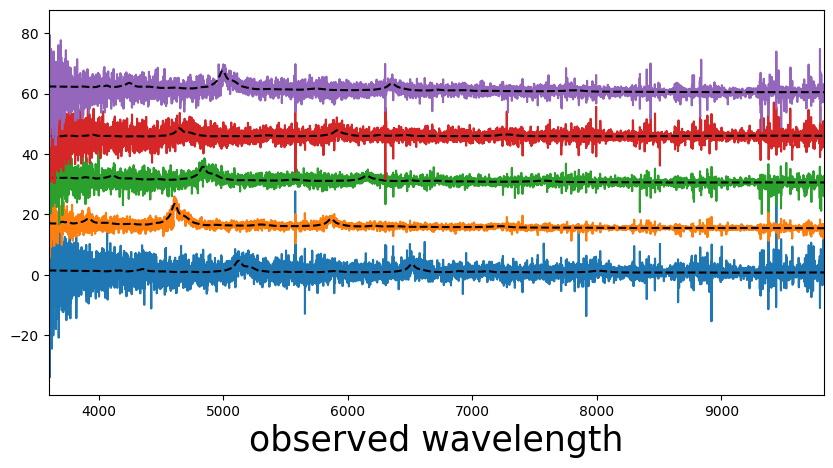

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for igal in range(5): 
    offset = igal * 15
    sub.plot(desiQSO.wave_obs, spec[igal] + offset)
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal] + offset, c='k', ls='--')    
sub.set_xlim(desiQSO.wave_obs[0], desiQSO.wave_obs[-1])
sub.set_xlabel('observed wavelength', fontsize=25)
plt.show()    

In [11]:
# save QSO spectra to batch
batch_size = 1024

counter, new_batch = 0, True

for dir_num0 in glob.glob('%s/*' % _dir): 
    dirs_num1 = glob.glob('%s/*' % dir_num0)
    for dir_num1 in dirs_num1: 
        num0 = int(dir_num0.split('/')[-1])
        num1 = int(dir_num1.split('/')[-1])
        if len(glob.glob('%s/*' % dir_num1)) == 0: continue 
        
        spec, w, z, target_id, norm, zerr, true_cont = prepare_spectra(num0, num1, zbin='high', verbose=False)
        
        if new_batch:
            batches = [spec, w, z, target_id, norm, zerr]
            batches_ = true_cont
            new_batch = False
        else:
            batches[0] = torch.concatenate([batches[0], spec], axis=0)
            batches[1] = torch.concatenate([batches[1], w], axis=0)
            batches[2] = torch.concatenate([batches[2], z], axis=0)
            batches[3] = torch.concatenate([batches[3], target_id], axis=0)
            batches[4] = torch.concatenate([batches[4], norm], axis=0)
            batches[5] = torch.concatenate([batches[5], zerr], axis=0)
            
            batches_ = torch.concatenate([batches_, true_cont], axis=0)

        N = batches[0].shape[0]
        while N > batch_size:
            batch = [_batch[:batch_size] for _batch in batches]
            batch_ = batches_[:batch_size]

            if counter > 277: 
                print(f"saving batch {counter}")
                desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso', batch, tag='london_highz', counter=counter)
                np.save('/global/cfs/projectdirs/desi/users/chahah/spender_qso/DESIlondon_highz_%i.true_cont.npy' % counter, batch_)
            counter += 1
            N -= batch_size

            batches = [_batch[batch_size:] for _batch in batches]   
            batches_ = batches_[batch_size:]

saving batch 278
saving batch 279
saving batch 280
saving batch 281
saving batch 282
saving batch 283
saving batch 284
saving batch 285
saving batch 286
saving batch 287
saving batch 288
saving batch 289
saving batch 290
saving batch 291
saving batch 292
saving batch 293
saving batch 294
saving batch 295
saving batch 296
saving batch 297
saving batch 298
saving batch 299
saving batch 300
saving batch 301
saving batch 302
saving batch 303
saving batch 304
saving batch 305
saving batch 306
saving batch 307
saving batch 308
saving batch 309
saving batch 310
saving batch 311
saving batch 312
saving batch 313
saving batch 314
saving batch 315
saving batch 316
saving batch 317
saving batch 318
saving batch 319
saving batch 320
saving batch 321
saving batch 322
saving batch 323
saving batch 324
saving batch 325
saving batch 326
saving batch 327
saving batch 328
saving batch 329
saving batch 330
saving batch 331
saving batch 332
saving batch 333
saving batch 334
saving batch 335
saving batch 3

In [17]:
batch = [_batch[:batch_size] for _batch in batches]
desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso', batch, tag='london_highz', counter=counter)

'/global/cfs/projectdirs/desi/users/chahah/spender_qso/DESIlondon_highz_392.pkl'

In [ ]:
desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso', batch, tag='london_highz', counter=counter)
#np.save('/global/cfs/projectdirs/desi/users/chahah/spender_qso/DESIlondon_highz_%i.true_cont.npy' % counter, batch)